**Финальный проект**

Постановка задачи: провести кластеризацию на реальном датасете предприятия, содержащем параметры заказов. Попробать выявить границы и физический смысл обнаруженных кластеров, а также найти неочевидные сегменты заказов.


In [3]:
# загрузка датасета
import pandas as pd

df = pd.read_csv('dataset.csv', sep=';', decimal=',')

--- Первые 5 строк ---
   Optic_TM    Th  Color  Lines  TO  TO_dens  Roll  NewGroup  NewCombo  Quant  \
0       1.0  20.0      8      2   1    11.02   360         0       0.0   7.71   
1       1.0  20.0      7      2   1    11.02   360         0       0.0   7.57   
2       1.0  20.0      8      2   1    11.02   360         0       0.0  10.48   
3       1.0  20.0      8      2   1    11.02   360         0       1.0  11.06   
4       1.0  20.0      8      2   1    11.02   360         0       0.0  17.46   

     Vs  Downtime  
0  3.06      0.00  
1  2.16      0.00  
2  4.20      0.00  
3  1.86      0.46  
4  4.56      0.26  
--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1776 entries, 0 to 1775
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Optic_TM  1776 non-null   float64
 1   Th        1776 non-null   float64
 2   Color     1776 non-null   int64  
 3   Lines     1776 non-null   int64  
 4   TO        1

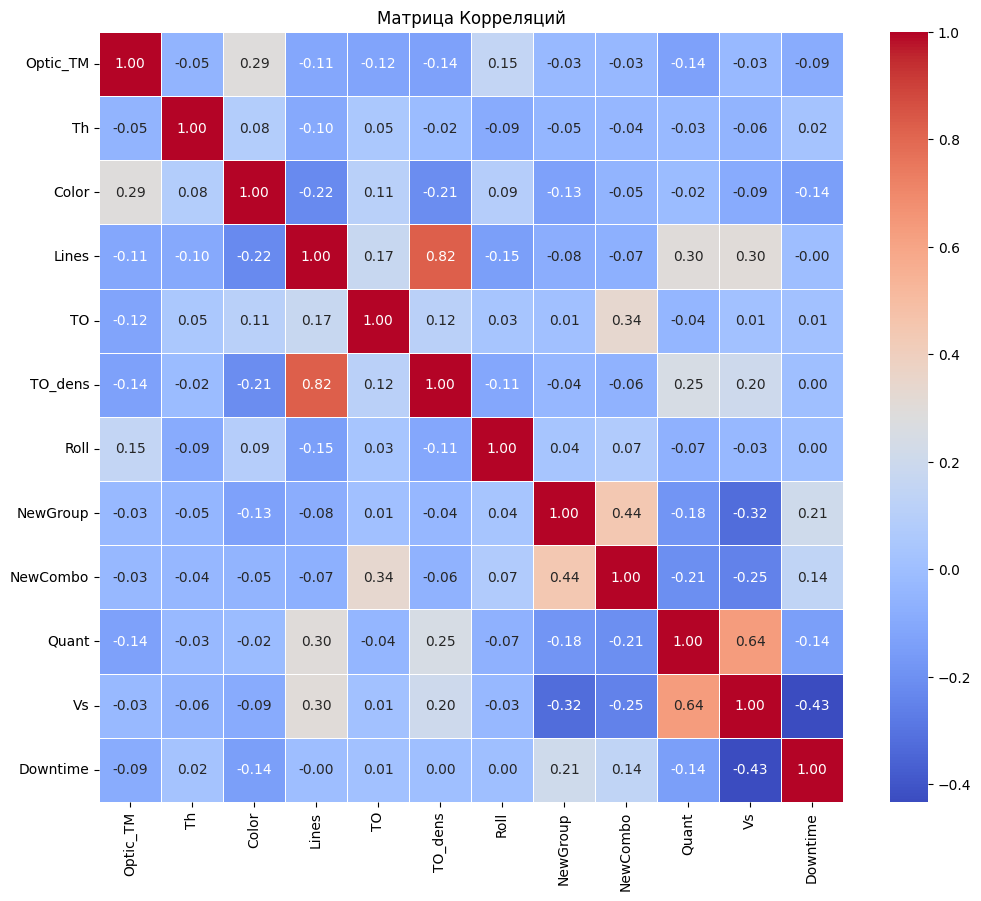

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Параметры:
# Optic_TM - свойство материала (1 - есть, 0/пусто - нет)
# Th - толщина
# Color - количество цветов
# Lines - количество линий
# TO - количество элементов
# TO_dens - плотность элементов
# Roll - параметр вращения
# NewGroup - есть новые элементы (1 - есть, 0/пусто - нет)
# NewCombo - новая комбинация (1 - да, 0/пусто - нет)
# Quant - количество
# Vs - скорость производства
# Downtime - время на технические донастройки (простои) в процессе выпуска

# заменим пустые значения на 0
df = df.fillna(0)

# анализ датасета
print('--- Первые 5 строк ---')
print(df.head())

print('--- Info ---')
print(df.info())

# матрица корреляций
correlation_matrix = df.corr()

# Визуализация матрицы корреляций с помощью Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Матрица Корреляций')
plt.show()

Видна коррелляция параметров TO_dens и Lines. Такая высокая корреляция не была очевидна. В дальнейшем исключим параметр Lines.


Доля объясненной дисперсии каждой компонентой:
[0.20974917 0.14835408 0.11613846 0.10536811 0.0812922  0.07730039
 0.07628789 0.06877902 0.05545165 0.03888095 0.02239807]

Кумулятивная объясненная дисперсия:
[0.20974917 0.35810326 0.47424172 0.57960983 0.66090203 0.73820242
 0.81449031 0.88326933 0.93872099 0.97760193 1.        ]


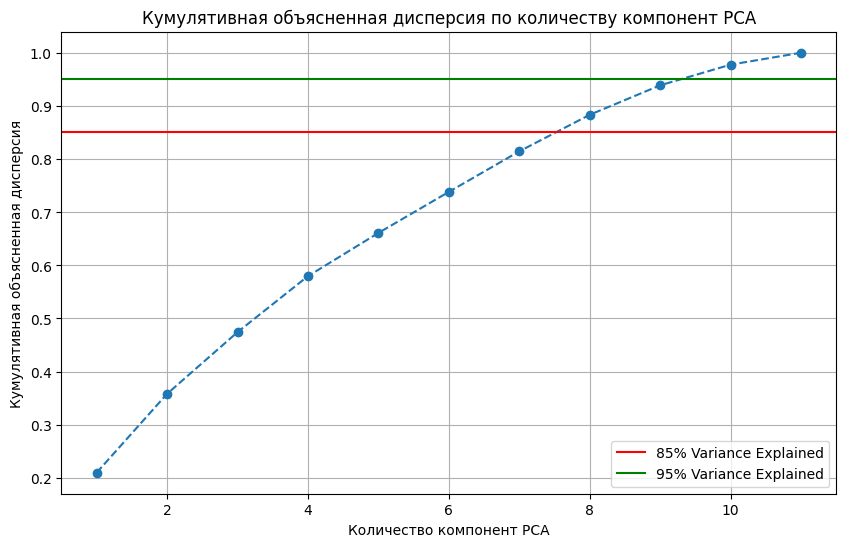

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(['Lines'], axis=1))  # исключаем Lines

# Применяем PCA, изначально не указывая n_components, чтобы посмотреть дисперсию для всех компонент
pca_full = PCA(random_state=42)
pca_full.fit(X_scaled)

# Смотрим на объясненную дисперсию каждой компоненты
print("\nДоля объясненной дисперсии каждой компонентой:")
print(pca_full.explained_variance_ratio_)

# Смотрим на кумулятивную объясненную дисперсию
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
print("\nКумулятивная объясненная дисперсия:")
print(cumulative_variance)

# Строим график кумулятивной объясненной дисперсии
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Кумулятивная объясненная дисперсия по количеству компонент PCA')
plt.xlabel('Количество компонент PCA')
plt.ylabel('Кумулятивная объясненная дисперсия')
plt.grid(True)
# Добавляем горизонтальные линии для ориентира (например, 85% и 95%)
plt.axhline(y=0.85, color='r', linestyle='-', label='85% Variance Explained')
plt.axhline(y=0.95, color='g', linestyle='-', label='95% Variance Explained')
plt.legend()
plt.show()

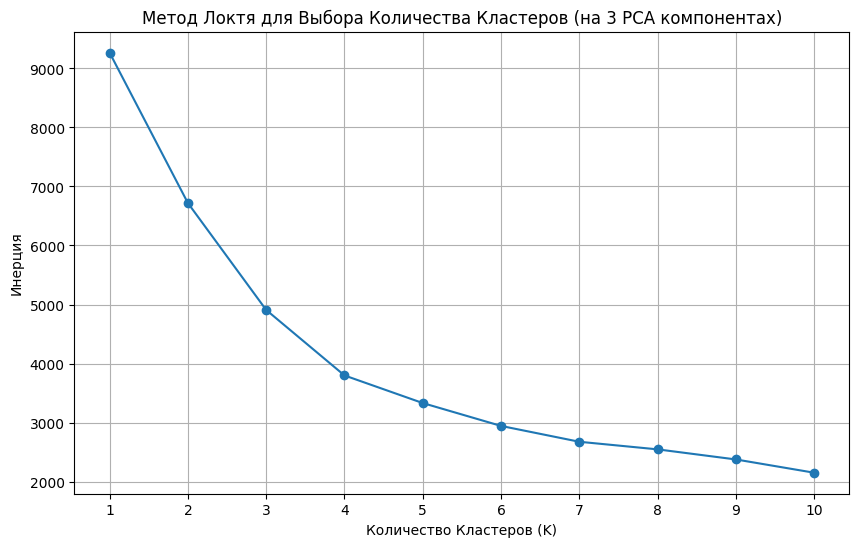

In [12]:
# Видим, что 8 компонент объясняют 90%
# Надо будет подумать над изначальным датасетом, провести расчеты с другими наборами параметров

# в рамках текущего проекта поработаем с перыми тремя компнентами
n_components_chosen = 3

# Применяем PCA с выбранным количеством компонент и трансформируем данные
pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# --- Метод Локтя для K-Means (на PCA-данных) ---
k_range = range(1, 11) # Попробуем от 1 до 10 кластеров
inertia_values = []

for k in k_range:
    # Создаем и обучаем модель K-Means для текущего K
    # init='k-means++' - умный способ инициализации центров
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init='auto')
    kmeans.fit(X_pca_3d) # Обучаем на 3D PCA-данных
    inertia_values.append(kmeans.inertia_)

# Строим график метода локтя
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_values, marker='o')
plt.title('Метод Локтя для Выбора Количества Кластеров (на 3 PCA компонентах)')
plt.xlabel('Количество Кластеров (K)')
plt.ylabel('Инерция')
plt.xticks(k_range) # Показываем все значения K на оси x
plt.grid(True)
plt.show()

In [19]:
# --- Выбор и Применение K-Means с Выбранным K ---
n_clusters_chosen = 7

# Применяем K-Means с выбранным K к данным после PCA
kmeans_final = KMeans(n_clusters=n_clusters_chosen, init='k-means++', random_state=42, n_init='auto')
kmeans_final.fit(X_pca_3d) # Обучаем на 3D PCA-данных

# Получаем метки кластеров для каждого объекта
cluster_labels = kmeans_final.labels_

# Добавляем метки кластеров обратно в исходный DataFrame для удобства интерпретации
df['Cluster'] = cluster_labels

# --- Визуализация Результатов Кластеризации в 3D ---
import plotly.express as px

# Подготовка данных для Plotly (нужен DataFrame)
df_plot = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
df_plot['Cluster'] = cluster_labels # Добавляем числовые метки кластеров
# Преобразуем метки кластеров в строковый тип для Plotly
df_plot['Cluster_Str'] = df_plot['Cluster'].astype(str)

fig = px.scatter_3d(
    df_plot,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Cluster_Str', # Используем строковые метки для дискретных цветов
    title=f'Результаты Кластеризации K-Means (K={n_clusters_chosen}) на Данных после PCA (3D) - Интерактивный',
    labels={'PC1': 'Компонента 1', 'PC2': 'Компонента 2', 'PC3': 'Компонента 3', 'Cluster_Str': 'Кластер'},
    # Настраиваем данные при наведении: показываем PC координаты и номер кластера
    hover_data={'PC1': ':.2f', 'PC2': ':.2f', 'PC3': ':.2f', 'Cluster': True, 'Cluster_Str': False}
)

# Отображаем интерактивный график
print("\nИнтерактивный график создан.")
fig.show()



Интерактивный график создан.


In [28]:
from sklearn.ensemble import IsolationForest

# поиск аномалий через Isolation Forest
model_if = IsolationForest(contamination=0.02, random_state=42) # допускаем до 2% аномалий

# Обучаем модель на масштабированных данных полной размерности (X_scaled)
model_if.fit(X_scaled)

# Получаем бинарное предсказание (-1 для аномалий, 1 для нормальных)
anomaly_predictions = model_if.predict(X_scaled)

# Получаем оценку аномальности (более низкое значение = более аномально)
anomaly_scores = model_if.decision_function(X_scaled)

# Добавляем предсказания и оценки аномальности обратно в исходный DataFrame
df['Anomaly_Prediction_IF'] = anomaly_predictions
df['Anomaly_Score_IF'] = anomaly_scores

print("\nРезультаты Isolation Forest добавлены в DataFrame ('Anomaly_Prediction_IF', 'Anomaly_Score_IF').")
print(f"Количество обнаруженных аномалий: {(df['Anomaly_Prediction_IF'] == -1).sum()}")

print("\nПостроение Интерактивного 3D Графика с раскраской по Аномалиям...")

# Подготовка данных для Plotly: используем X_pca_3d и добавляем колонки аномалий из df
df_plot_anomalies = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])

# Добавляем колонки с результатами Isolation Forest из df
# Убедимся, что индексы совпадают, т.к. мы работаем с преобразованными данными из df
df_plot_anomalies['Anomaly_Prediction_IF'] = df['Anomaly_Prediction_IF'].values
df_plot_anomalies['Anomaly_Score_IF'] = df['Anomaly_Score_IF'].values

df_plot_anomalies['Cluster'] = cluster_labels
df_plot_anomalies['Cluster_Str'] = df_plot_anomalies['Cluster'].astype(str)

print('--- Построение Интерактивного 3D Графика с раскраской по ПРЕДСКАЗАНИЮ аномалий ---')
# Раскрашиваем по бинарному предсказанию (-1 или 1)
fig_pred = px.scatter_3d(
    df_plot_anomalies,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Anomaly_Prediction_IF', # Раскрашиваем по предсказанию аномалий (-1 или 1)
    title='Аномалии (Isolation Forest) на Данных PCA (3D) - Предсказание',
    labels={'PC1': 'Главная Компонента 1', 'PC2': 'Главная Компонента 2', 'PC3': 'Главная Компонента 3', 'Anomaly_Prediction_IF': 'Аномалия (-1) / Норма (1)'},
    hover_data={'PC1': ':.2f', 'PC2': ':.2f', 'PC3': ':.2f', 'Anomaly_Prediction_IF': True, 'Anomaly_Score_IF': ':.2f'} # Показываем предсказание и оценку при наведении
)
fig_pred.show()

print('--- Построение Интерактивного 3D Графика с раскраской по ОЦЕНКЕ аномальности ---')
# Раскрашиваем по непрерывной оценке аномальности
fig_score = px.scatter_3d(
    df_plot_anomalies,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Anomaly_Score_IF', # Раскрашиваем по оценке аномальности (непрерывное значение)
    color_continuous_scale=px.colors.sequential.Viridis, # Цветовая шкала (можно выбрать другую)
    title='Аномалии (Isolation Forest) на Данных PCA (3D) - Оценка',
    labels={'PC1': 'Компонента 1', 'PC2': 'Компонента 2', 'PC3': 'Компонента 3', 'Anomaly_Score_IF': 'Оценка Аномальности'},
      hover_data={'PC1': ':.2f', 'PC2': ':.2f', 'PC3': ':.2f', 'Anomaly_Prediction_IF': True, 'Anomaly_Score_IF': ':.2f'} # Показываем предсказание и оценку при наведении
)
fig_score.show()


Результаты Isolation Forest добавлены в DataFrame ('Anomaly_Prediction_IF', 'Anomaly_Score_IF').
Количество обнаруженных аномалий: 36

Построение Интерактивного 3D Графика с раскраской по Аномалиям...
--- Построение Интерактивного 3D Графика с раскраской по ПРЕДСКАЗАНИЮ аномалий ---


--- Построение Интерактивного 3D Графика с раскраской по ОЦЕНКЕ аномальности ---
